**Analysis owner**: Tamiris Crepalde <br>
**Date**: 09/01/2023 <br>

This analysis pretends to do an Exploratory Data Analysis of cancellations of travel packages.

As explained in the [README.md](/README.md), packages are a type of travel product that include flight tickets and hotel reservations, and in this analysis we try to explore packages cancellation data.

It's intended to answer the following business questions:
- a
- b
- Are most of the orders canceled due to delays in the operation process?

#### Summary 

1. Setup
<br></br>
2. Load data
<br></br>
3. Cleaning and Preprocess
<br></br>
4. Analysis  
   - Categorical features
   - Date features
   - Numerical features
<br></br>
5. Modelling - Feature Importance
<br></br>
6. Conclusions

### Setup

In [1]:
import os
from datetime import datetime as dt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import src.featuring.featuring_columns_utils as feat
import src.utils as utils
import src.visualization.visualization_utils as visuals
from GoogleUtils import GoogleUtils

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
gutils = GoogleUtils()

### Load data

In [3]:
root = os.getcwd()

The data can be recover from BigQuery or from a local csv file:

In [4]:
# to query from Google BigQuery

query = utils.read_file(f'{root}/src/queries/package_data.sql')
package_data = gutils.read_from_bq(query)


# save locally

package_data.to_csv(f'{root}/src/data/package_data.csv', index=False)

In [5]:
# to read local file

package_data = pd.read_csv(f'{root}/src/data/package_data.csv')

In [6]:
package_data.head()

,operation_id,order_id,order_date,origin_city,origin_state,origin_country,destination_type,destination_city,destination_state,destination_country,...,last_valid_date,first_possible_wish_date,first_wish_date,second_wish_date,third_wish_date,operation_status_id,operation_status_name,status_name,last_update_status_date,qty_status_changes
0,-2.638801e+18,1478524431003886863,2019-11-08,São Paulo,São Paulo,Brasil,Nacional,Ipojuca,Pernambuco,Brasil,...,2022-11-30,NaN,2020-09-04,2020-09-11,2020-09-18,7.0,"Finalizado, voucher emitido",Aprovado,2019-11-08,1
1,-7.330006e+18,1633940472103524305,2019-11-30,Rio de Janeiro,Rio de Janeiro,Brasil,Nacional,Jijoca de Jericoacoara,Ceará,Brasil,...,2022-11-30,NaN,2022-04-25,2022-04-30,2022-05-05,7.0,"Finalizado, voucher emitido",Aprovado,2019-11-30,1
2,1.296159e+18,2062117018421537878,2020-03-11,Rio de Janeiro,Rio de Janeiro,Brasil,Nacional,Ilhéus,Bahia,Brasil,...,2023-11-30,NaN,2022-10-18,2022-10-26,2022-11-03,10.0,Cotação aérea rejeitada,Aprovado,2020-03-11,1
3,NaN,-2926260025169751076,2020-04-13,Rio de Janeiro,Rio de Janeiro,Brasil,Nacional,Praia da Pipa,Rio Grande do Norte,Brasil,...,2022-11-30,NaN,2021-06-01,2021-06-09,2021-11-17,NaN,NaN,Devolvido,2021-11-17,3
4,-4.803600e+18,-43270482611080565,2020-04-16,Rio de Janeiro,Rio de Janeiro,Brasil,Internacional,Jerusalém,Jerusalém,Israel,...,2022-11-30,NaN,2022-05-27,2022-06-24,2022-06-30,7.0,"Finalizado, voucher emitido",Aprovado,2020-04-16,1


### Cleaning & Preprocess

We have a lot of null values:

In [7]:
package_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 971220 entries, 0 to 971219
Data columns (total 27 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   operation_id              790992 non-null  float64
 1   order_id                  971220 non-null  int64  
 2   order_date                971220 non-null  object 
 3   origin_city               971220 non-null  object 
 4   origin_state              971220 non-null  object 
 5   origin_country            971220 non-null  object 
 6   destination_type          971220 non-null  object 
 7   destination_city          971220 non-null  object 
 8   destination_state         971220 non-null  object 
 9   destination_country       971220 non-null  object 
 10  qty_people                971220 non-null  int64  
 11  qty_dailies               971220 non-null  int64  
 12  accommodation_type        971220 non-null  object 
 13  filled_form               971220 non-null  o

- `first_possible_wish_date` is almost completely empty, so we'll remove the column.


- The feature `operation_id` indicates if the order started the process of being operated before the cancellation and the features `operation_status_id` and `operation_status_name` indicates the status of the operation process. The first feature we'll convert to boolean because we want to analyze if the client cancelled the order after the operation process started, and if a order was cancelled before the start of the operation, this information doesn't exists. Therefore, almost 49% of the cases were cancelled after their operation start.


- The column `accommodation_type` has some missing data, we're going to look further on it before deciding if it will me removed or filled up.


- We can drop the `origin_country` column because this product is offer only to Brazil.


- The feature `filled_form` is related to the client inform the desired dates to travel, so is enough if this information is boolean too. `first_form_fill_date` and `last_form_fill_date` are related to the first and last date in which the client filled up the form, we'll use these features only to verify if the process of filling up the form and the cancellation are close events. For this we need only the last_form_fill_date.


- The columns `first_wish_date`, `second_wish_date` and `third_wish_date` are the wished dates to travel informed by half of the clients, at a first moment we'll not be concern about these information. The columns will be dropped.


- The `status_name` will be used to differentiate canceled orders to not canceled ones. It'll be converted to boolean.


Next we'll proceed to execute these modifications.

In [8]:
((package_data.isna().sum()/package_data.shape[0])*100).sort_values(ascending=False)

first_possible_wish_date    99.197504
operation_id                18.556867
operation_status_name       18.556867
operation_status_id         18.556867
third_wish_date              0.000309
second_wish_date             0.000309
first_wish_date              0.000309
first_form_fill_date         0.000000
last_update_status_date      0.000000
status_name                  0.000000
last_valid_date              0.000000
first_valid_date             0.000000
last_form_fill_date          0.000000
filled_form                  0.000000
order_id                     0.000000
accommodation_type           0.000000
qty_dailies                  0.000000
qty_people                   0.000000
destination_country          0.000000
destination_state            0.000000
destination_city             0.000000
destination_type             0.000000
origin_country               0.000000
origin_state                 0.000000
origin_city                  0.000000
order_date                   0.000000
qty_status_c

Converting columns to boolean:

In [9]:
df = utils.convert_to_boolean(package_data, 'operation_id', 'operation_started')
df = utils.convert_to_boolean(df, 'filled_form')
df = utils.convert_to_boolean(df, 'status_name', 'order_canceled', 'Devolvido')

Drop columns containing:
- unique identifiers
- information about origin country
- wish dates
- first form filling date
- duplicate information

In [10]:
df = df.drop([
    'first_possible_wish_date',
    'operation_status_id', 
    'operation_status_name',
    'origin_country', 
    'first_form_fill_date',
    'first_wish_date', 
    'second_wish_date', 
    'third_wish_date',
    'operation_id', 
    'order_id',
    'status_name'
], axis=1)

First of all, let's see the proportion between canceled orders and not canceled orders, to get a better understanding of the data.

So, we known that almost 30% of the orders were canceled.

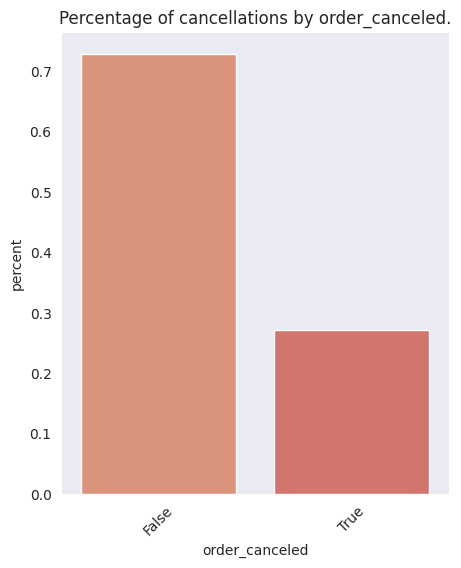

In [11]:
visuals.single_barplot(df, 'order_canceled')

Looking at accommodation_type:

It's possible to notice that the column has the information of type varying even for the same room type. For instance, `Apartamento duplo` and `Apartamento duplo casal`. So we'll try to extract the main information of the column (individual, duplo, triplo, etc). In the cases where there's more than one option, we'll attribute a new type `multiple`. We'll attribute `not informed` for missing data, and then we'll anonymize the information.

In [12]:
df.accommodation_type

0                                        Apartamento duplo.
1                                        Apartamento duplo.
2                          Apartamento individual ou duplo.
3                                        Apartamento duplo.
4                                        Apartamento duplo.
                                ...                        
971215                            Apartamento duplo casal. 
971216                                   Apartamento Duplo.
971217    Quarto individual, duplo ou triplo, de acordo ...
971218    Quarto individual, duplo ou triplo, de acordo ...
971219    Quarto individual, duplo ou triplo, de acordo ...
Name: accommodation_type, Length: 971220, dtype: object

In [13]:
df.loc[df.accommodation_type.isna(), 'accommodation_type'] = 'not informed'

In [14]:
df = feat.treat_accom_type(df, 'accommodation_type')
df = feat.anonymize_data(df, ['accommodation_type'], 'accommodation')

Three categories represent 99% of the cases, so we'll remove the others.

In [15]:
df.groupby('accommodation_type').count()['order_date'].sort_values(ascending=False).cumsum()/df.accommodation_type.count()

accommodation_type
accommodation_3     0.621864
accommodation_1     0.962411
accommodation_2     0.996105
accommodation_7     0.999398
accommodation_6     0.999851
accommodation_4     0.999925
accommodation_5     0.999994
accommodation_9     0.999998
accommodation_10    0.999999
accommodation_8     1.000000
Name: order_date, dtype: float64

The categories we'll remove represent less than 1% of the data:

In [16]:
df.loc[~df.accommodation_type.isin(['accommodation_3', 'accommodation_2', 'accommodation_1'])].accommodation_type.count()/df.accommodation_type.count()

0.0038951010069809104

In [17]:
df = df.loc[df.accommodation_type.isin(['accommodation_3', 'accommodation_2', 'accommodation_1'])]

There're no more null values:

In [18]:
((df.isna().sum()/df.shape[0])*100).sort_values(ascending=False)

order_date                 0.0
origin_city                0.0
operation_started          0.0
qty_status_changes         0.0
last_update_status_date    0.0
last_valid_date            0.0
first_valid_date           0.0
last_form_fill_date        0.0
filled_form                0.0
accommodation_type         0.0
qty_dailies                0.0
qty_people                 0.0
destination_country        0.0
destination_state          0.0
destination_city           0.0
destination_type           0.0
origin_state               0.0
order_canceled             0.0
dtype: float64

We're going to anonymize the cities and states names:

In [19]:
df = feat.anonymize_data(df, ['origin_city', 'destination_city'], 'city')
df = feat.anonymize_data(df, ['origin_state', 'destination_state'], 'state')
df = feat.anonymize_data(df, ['destination_country'], 'country')

Now we're going to change the dtype of some columns:

In [20]:
df = feat.convert_to_datetime(df, ['order_date', 'first_valid_date', 'last_valid_date', 'last_update_status_date', 'last_form_fill_date'])
df = feat.convert_to_int(df, ['qty_people', 'qty_dailies'])

### Analysis

#### Categorical

Let's start analyzing the data taking a look into the categorical data.

In [21]:
categorical_features = df.select_dtypes(include=['object_']).columns
categorical_features

Index(['origin_city', 'origin_state', 'destination_type', 'destination_city',
       'destination_state', 'destination_country', 'accommodation_type',
       'filled_form', 'operation_started', 'order_canceled'],
      dtype='object')

##### Origins

Thinking about volume, the best-selling state destinations are also the most canceled ones. But proportionally, the best seller state_2 has approximately the same amount of cancellations than the top 4 sellers.

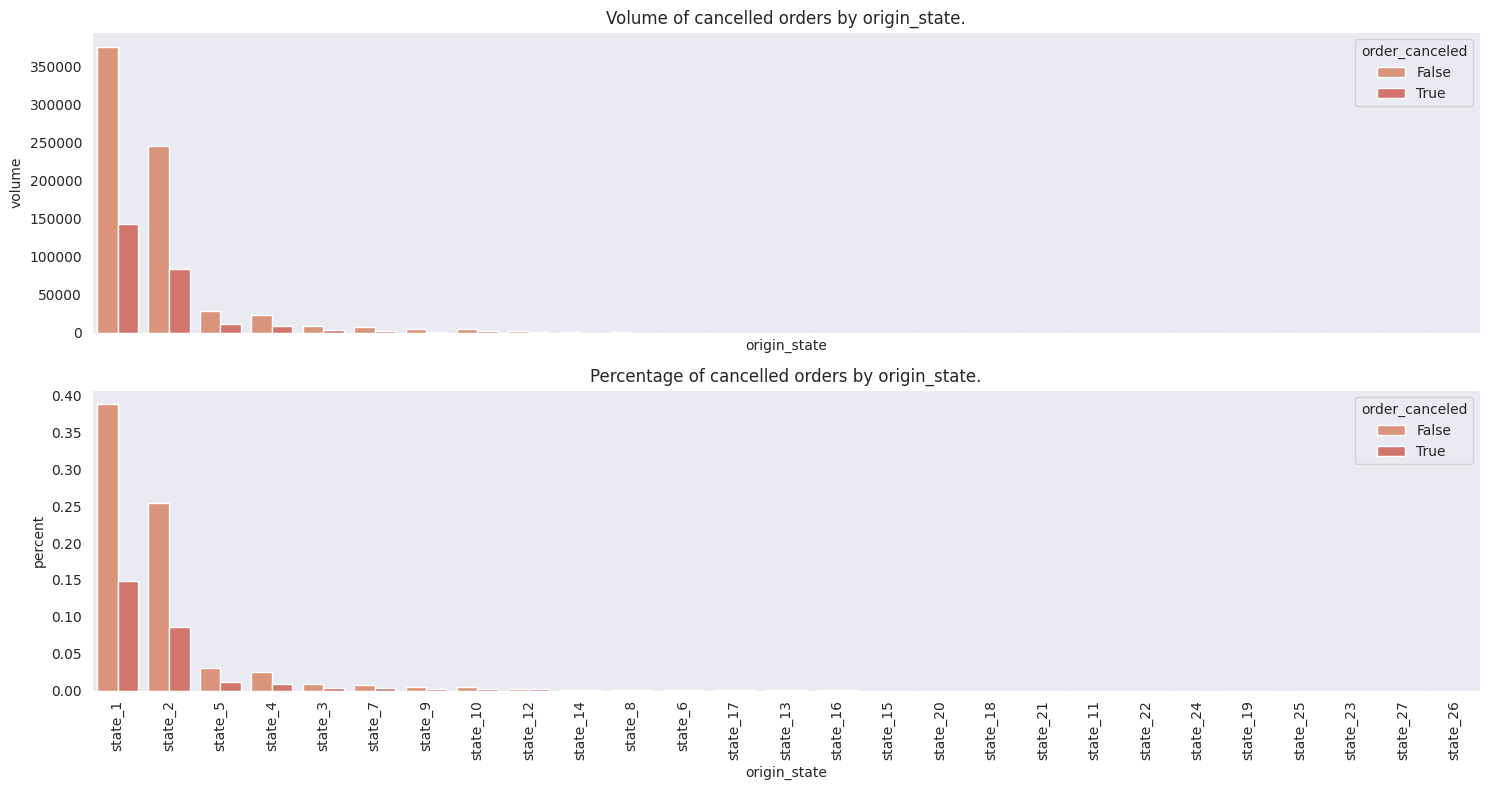

In [22]:
visuals.double_barplot(df, 'origin_state', hue='order_canceled')

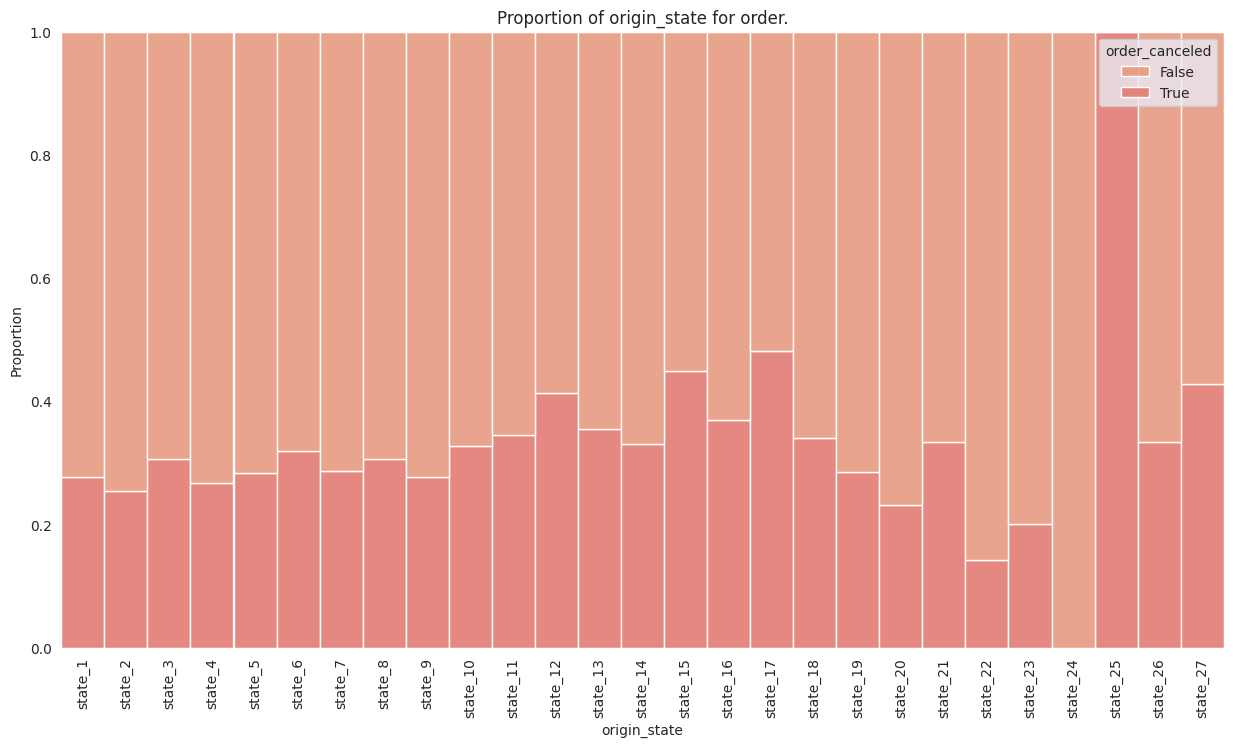

In [23]:
visuals.single_histplot(df, 'origin_state', hue='order_canceled', multiple='fill', bins=27)

For the origin cities, we have a similar performance to the origin states: two origins with most of the sales and cancellations and the top-sellers with similar proportions of cancellations.

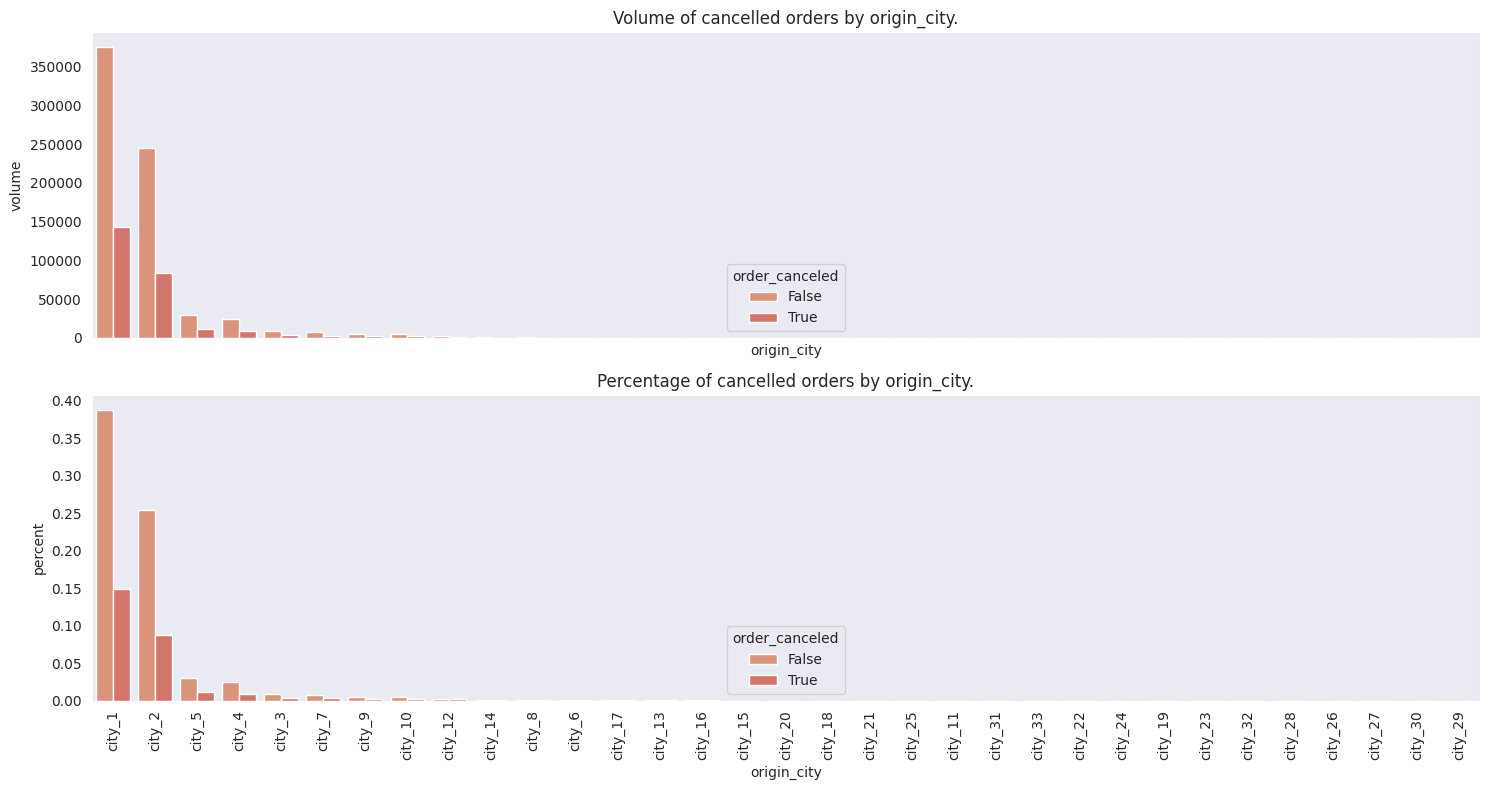

In [24]:
visuals.double_barplot(df, 'origin_city', hue='order_canceled')

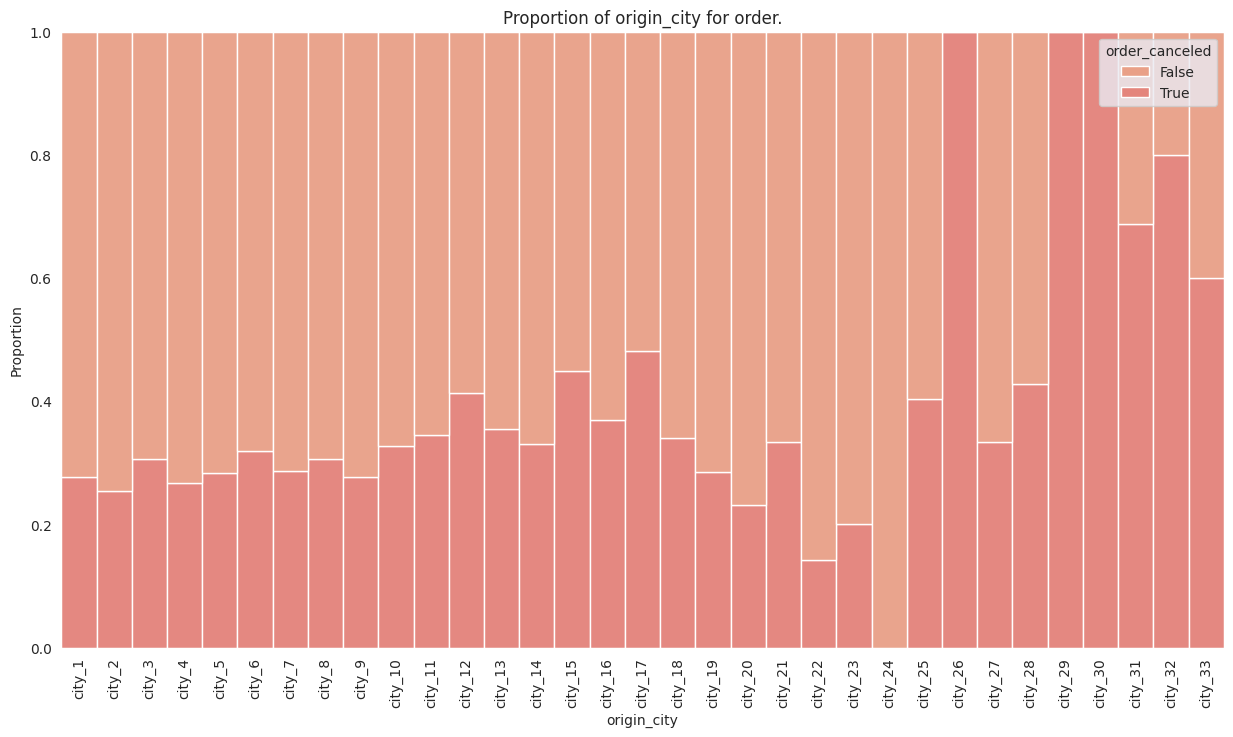

In [25]:
visuals.single_histplot(df, 'origin_city', hue='order_canceled', multiple='fill')

##### Destinations

More than 50% of the cancellations have national destination (Brazil), but international destinations have slightly more cancellations, proportionally.

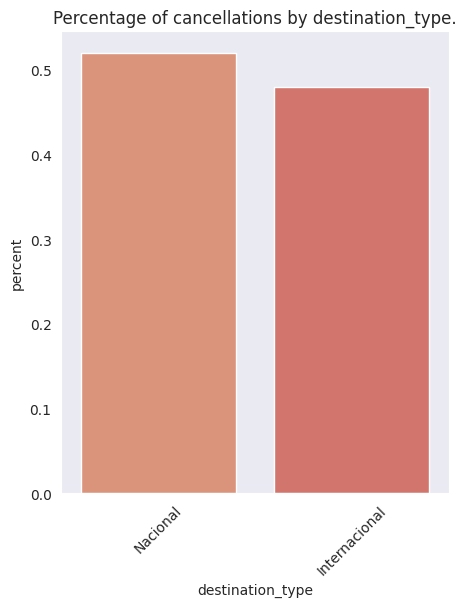

In [26]:
visuals.single_barplot(df.loc[df.order_canceled == True], 'destination_type')

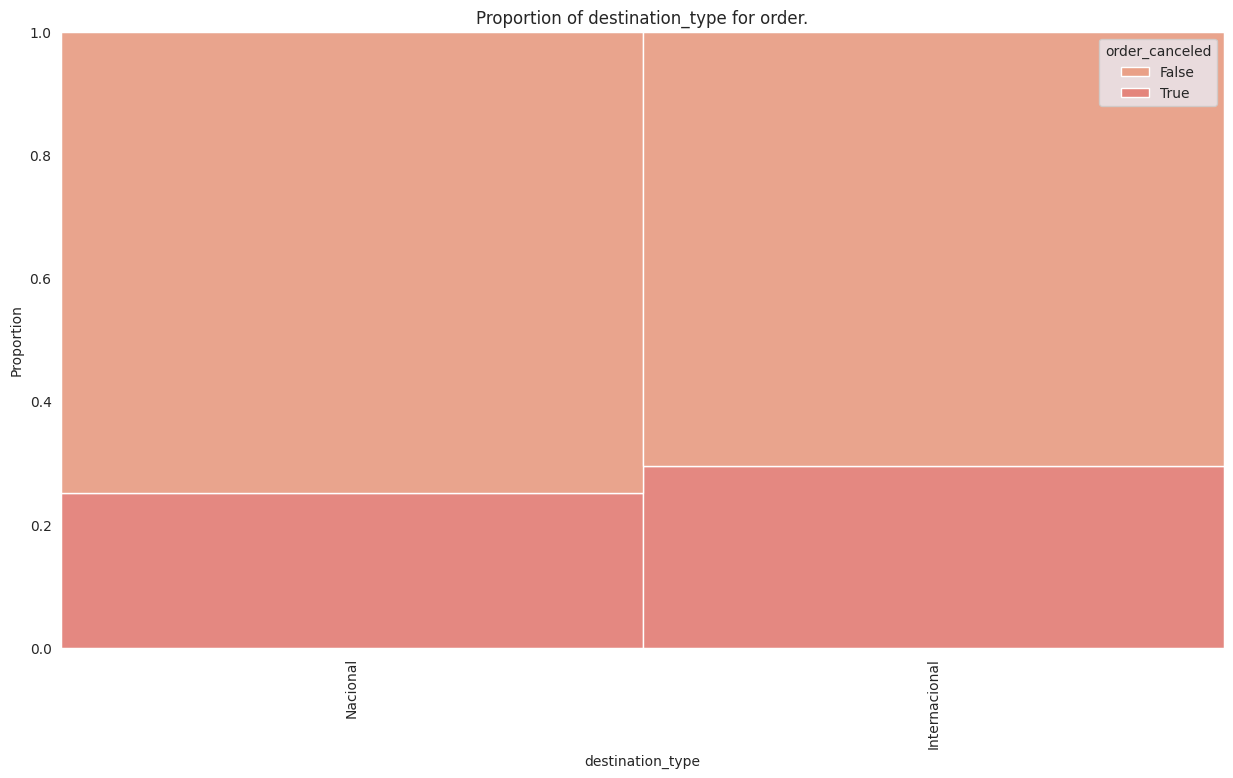

In [27]:
visuals.single_histplot(df, 'destination_type', hue='order_canceled', multiple='fill')

More thant 50% of the cancelled orders had Brazil as destination. The second destination with more cancellations is USA.

It would be interesting to understand the proportion of these cases on the overall purchase statistics, but we have no current access to this data.

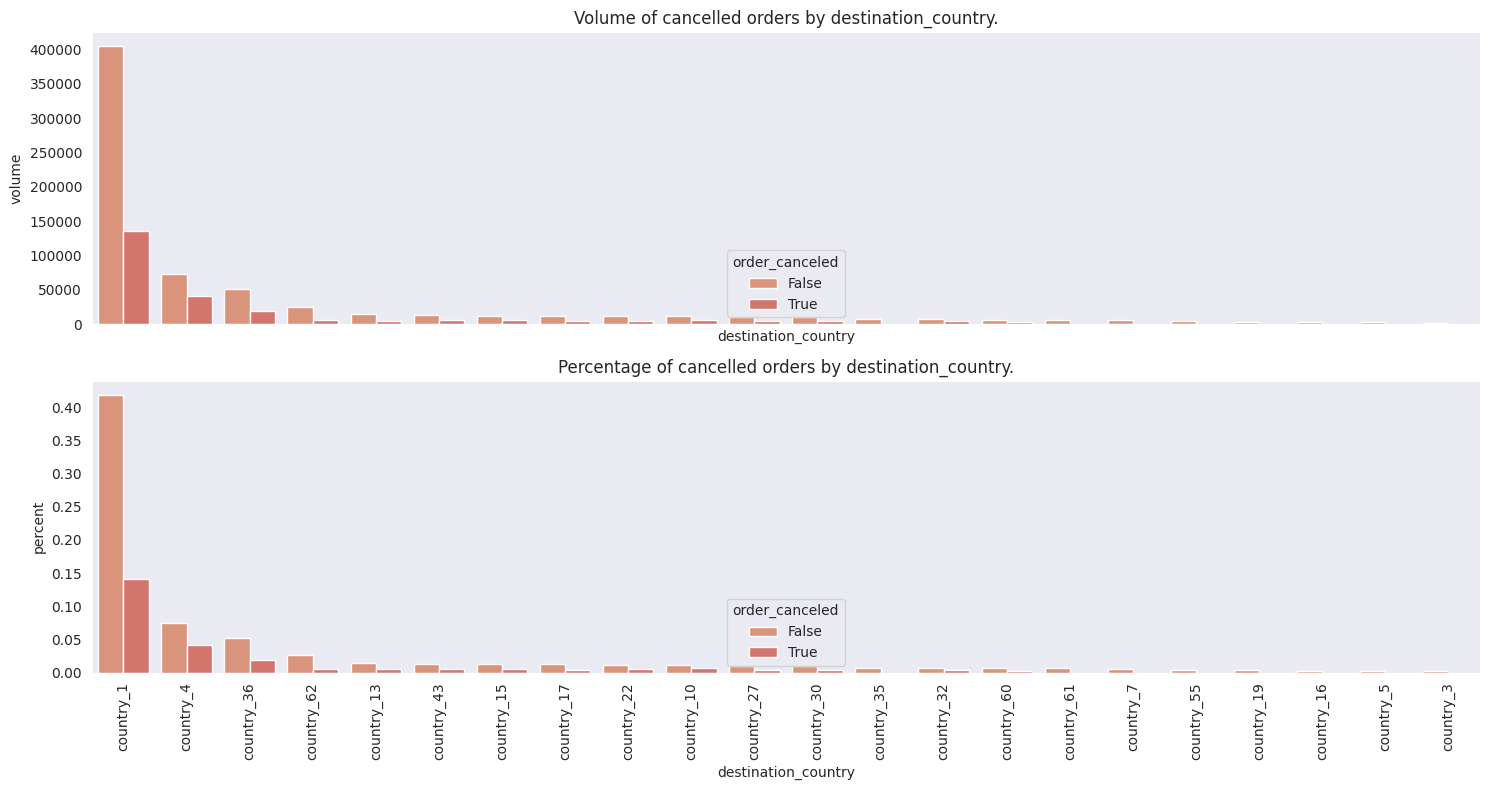

In [28]:
visuals.double_barplot(df, 'destination_country', 35, hue='order_canceled')

In [29]:
dest_country_grp = utils.group_data(df, ['destination_country', 'order_canceled'])
top_countries = dest_country_grp.destination_country.loc[:35].values

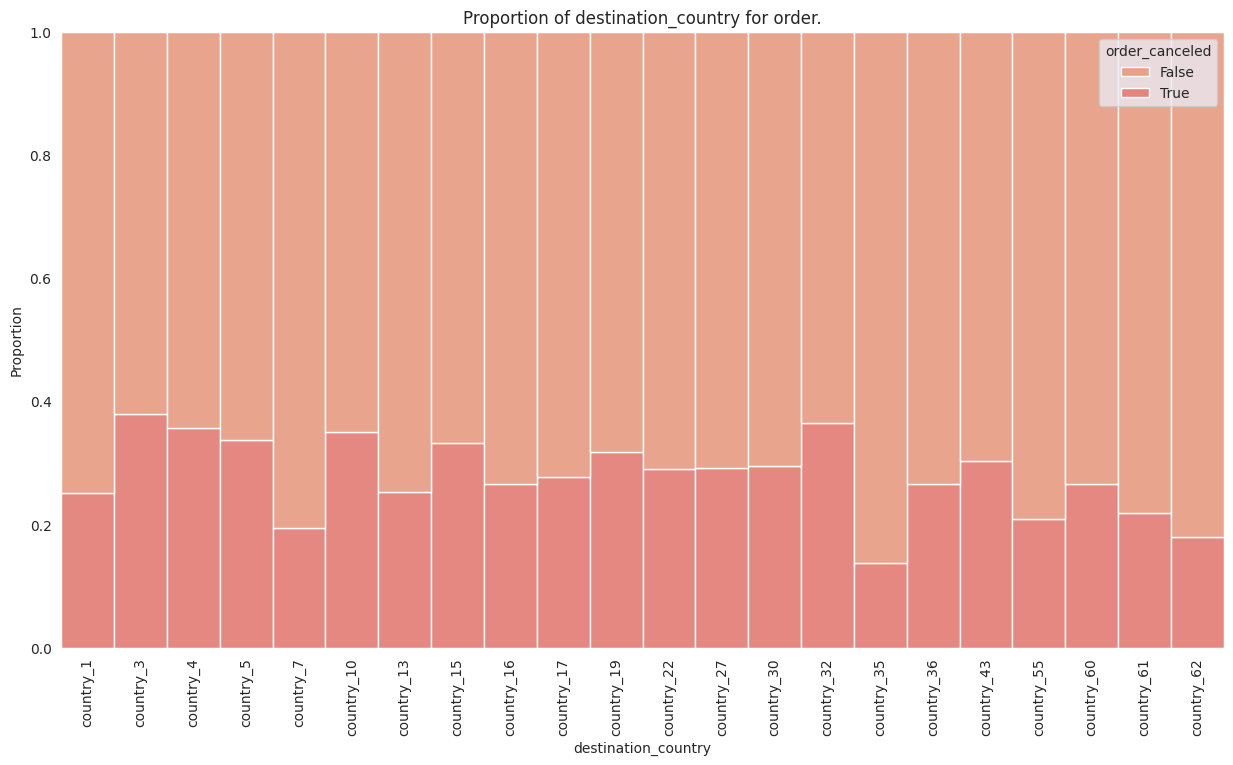

In [30]:
visuals.single_histplot(df.loc[df.destination_country.isin(top_countries)], 'destination_country', hue='order_canceled', multiple='fill')

We limited the plot to the top 35 destination states to keep the graph interpretable. It's possible to verify that in the top 10 destination state we have only two that are international: Flórida and Quintana Roo.

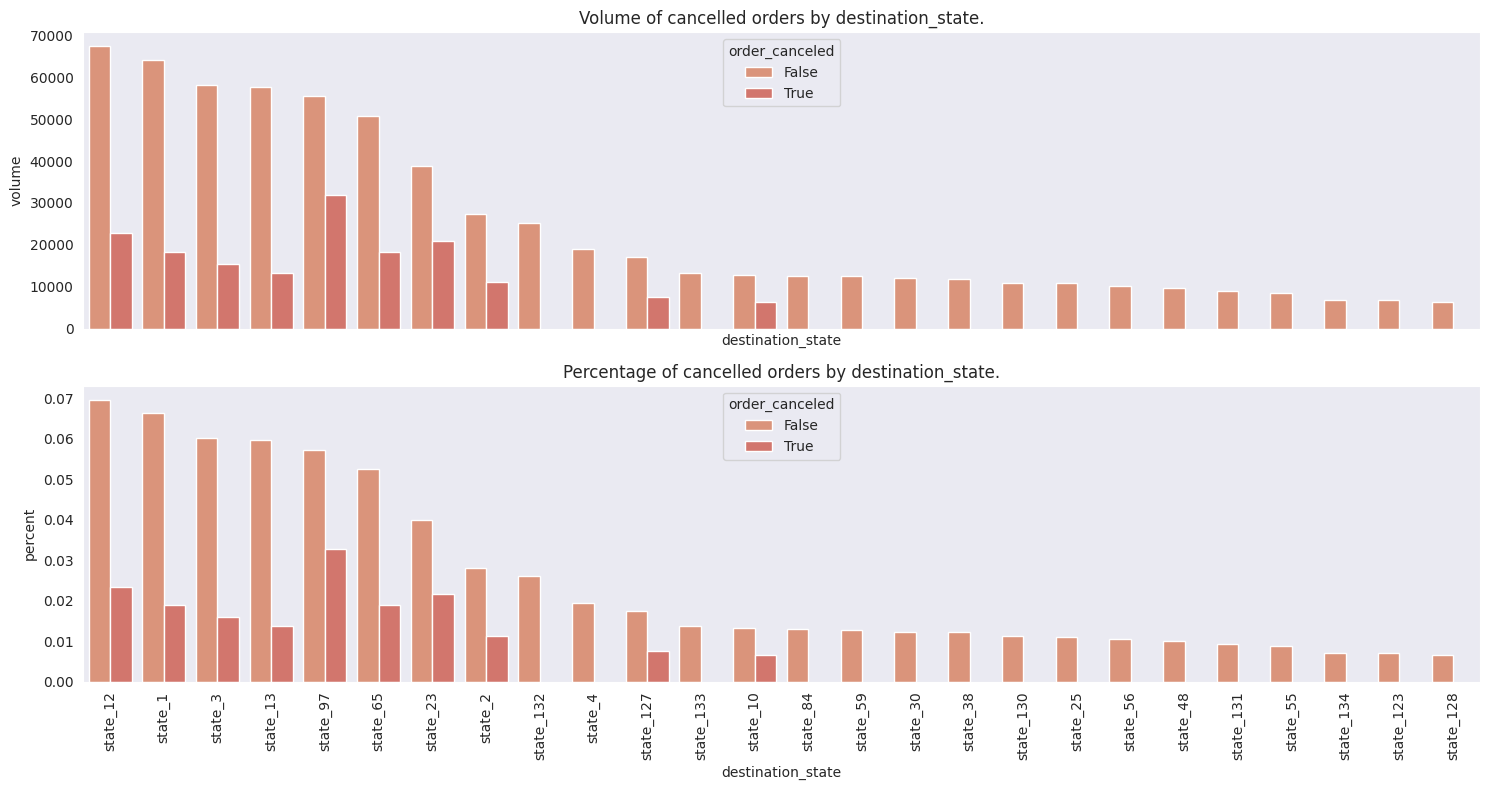

In [31]:
visuals.double_barplot(df, 'destination_state', 35, hue='order_canceled')

In [32]:
dest_state_grp = utils.group_data(df, ['destination_state', 'order_canceled'])
top_states = dest_state_grp.destination_state.loc[:35].values

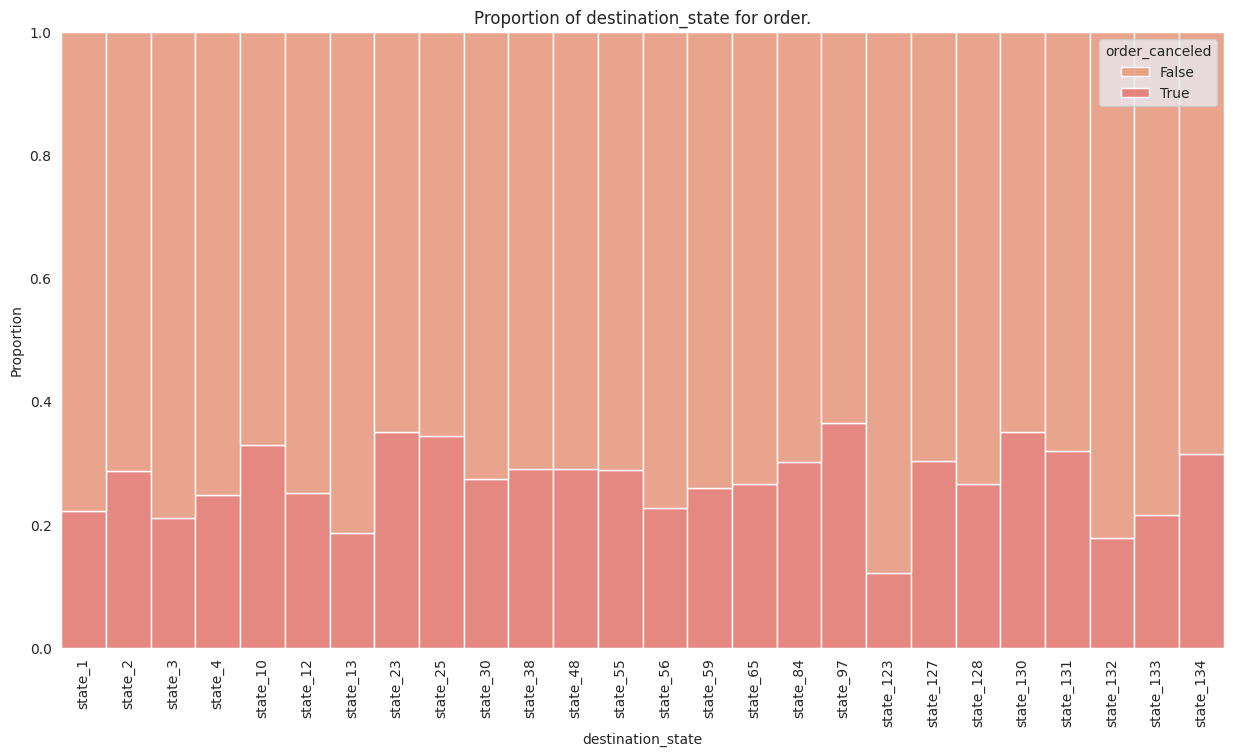

In [33]:
visuals.single_histplot(df.loc[df.destination_state.isin(top_states)], 'destination_state', hue='order_canceled', multiple='fill')

Among the top cities within cancellations, we have the cities related to the international states mentioned before: Orlando (Florida) and Cancún (Quintana Roo). And a lot of Brazilian cities.

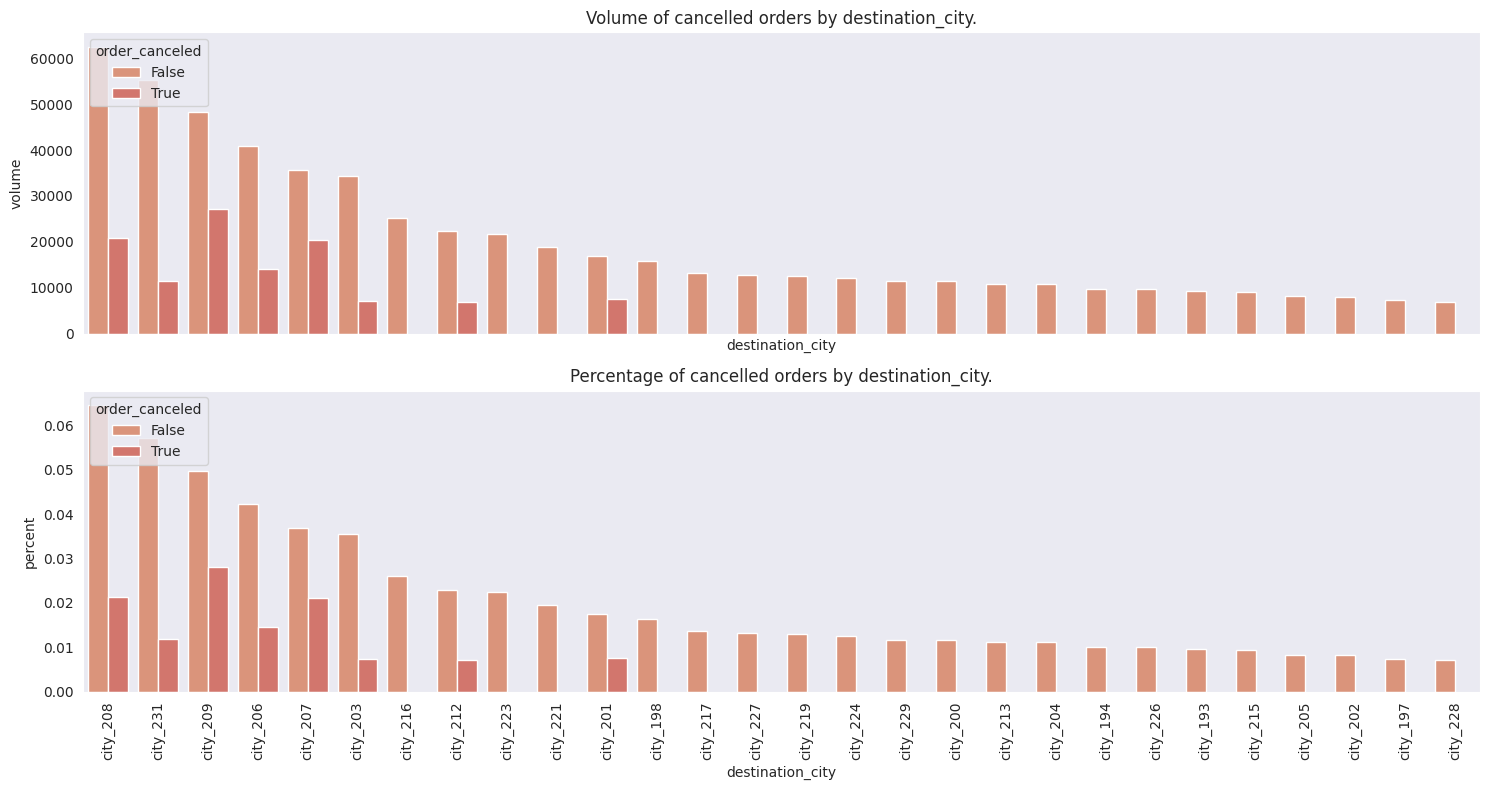

In [34]:
visuals.double_barplot(df, 'destination_city', 35, hue='order_canceled')

In [35]:
dest_city_grp = utils.group_data(df, ['destination_city', 'order_canceled'])
top_cities = dest_city_grp.destination_city.loc[:35].values

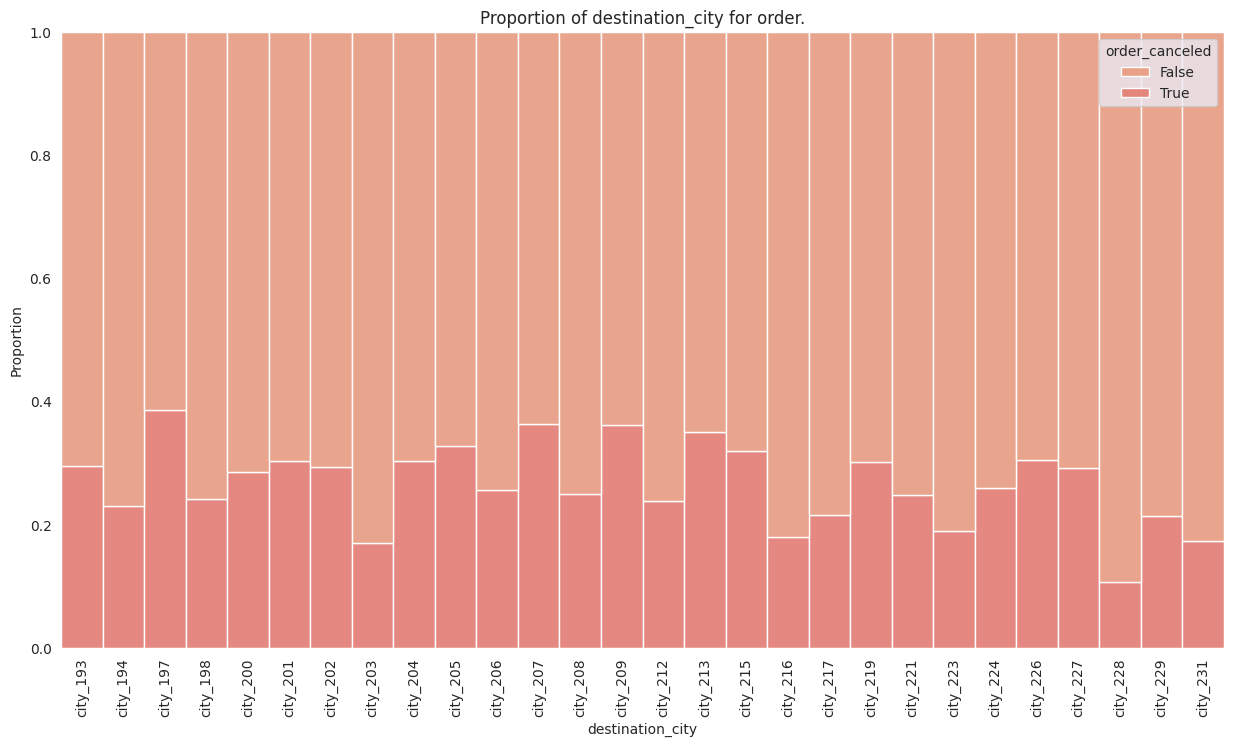

In [36]:
visuals.single_histplot(df.loc[df.destination_city.isin(top_cities)], 'destination_city', hue='order_canceled', multiple='fill')

##### Accomodations

We already selected the main categories of accommodation_type, the categories 'multiple' and 'duplo' have similar proportions.

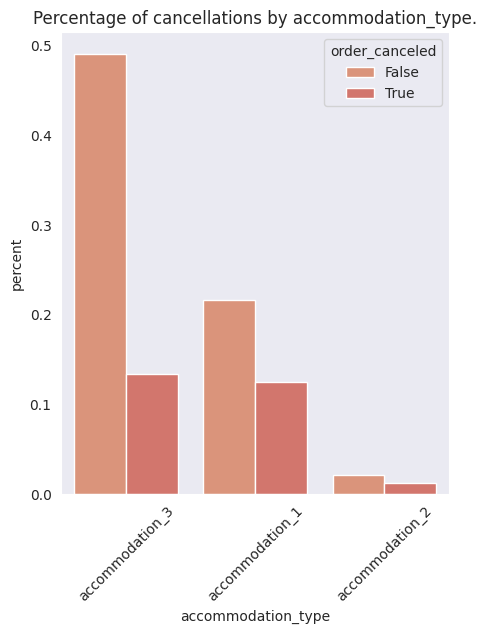

In [37]:
visuals.single_barplot(df, 'accommodation_type', hue='order_canceled')

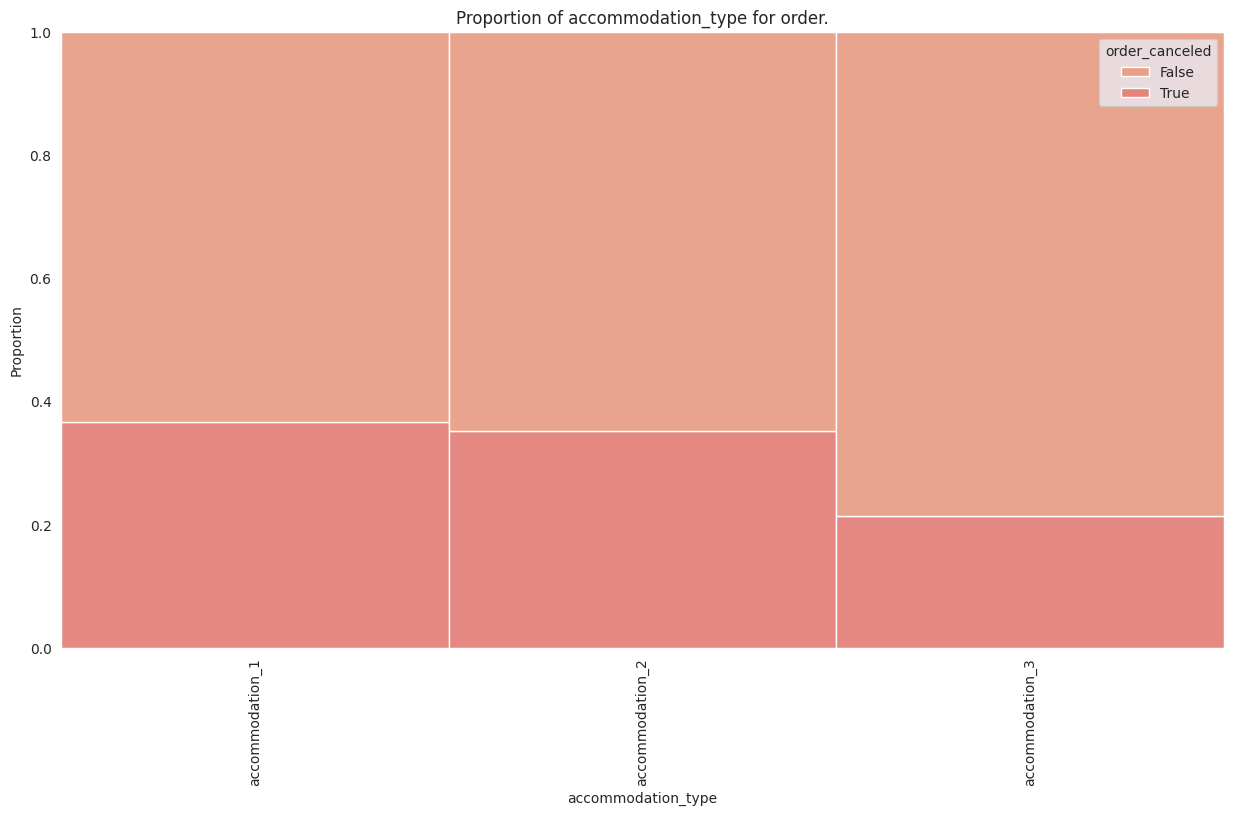

In [38]:
visuals.single_histplot(df, 'accommodation_type', hue='order_canceled', multiple='fill')

##### Filled Forms

In all cases the form was filled up, so we can discard this feature.

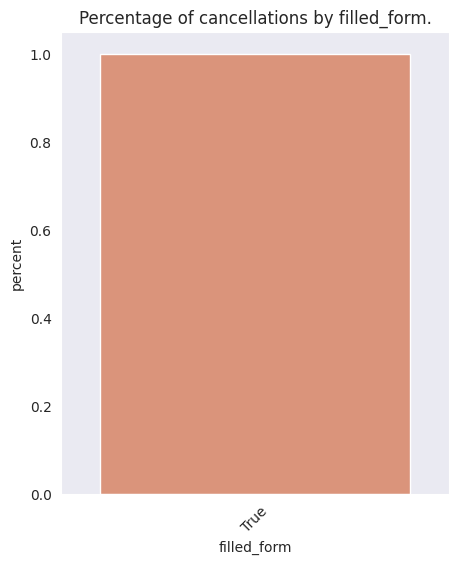

In [39]:
visuals.single_barplot(df, 'filled_form')

In [40]:
df = df.drop('filled_form', axis=1)

##### Operation status

More than a half of the cases had their operations started before the cancellation.

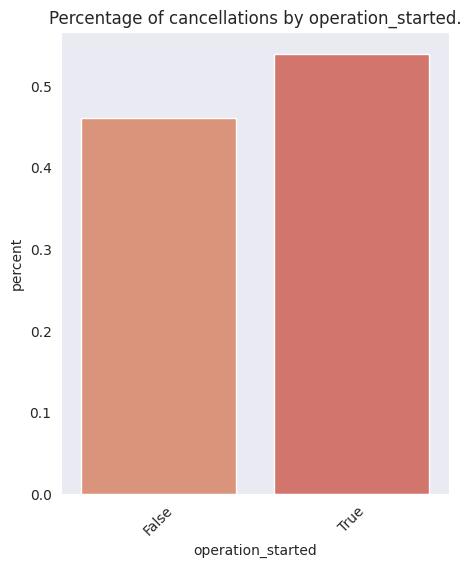

In [41]:
visuals.single_barplot(df.loc[df.order_canceled == True], 'operation_started')

#### Datetime features

In [42]:
datetime_features = df.select_dtypes(include=['datetime']).columns
datetime_features

Index(['order_date', 'last_form_fill_date', 'first_valid_date',
       'last_valid_date', 'last_update_status_date'],
      dtype='object')

In [43]:
df_dates = utils.create_date_columns(df, ['first_valid_date', 'last_form_fill_date', 'last_update_status_date', 'last_valid_date', 'order_date'])

Let's compute the difference between the order_date and the last_update_status_date to verify the difference between the purchases and it's cancellations.

There is no time_to_cancel with more than 5% of share in the sample, the most representative is 0 days to cancel, but the data have a high cardinality.

We have a better visualization with a month granularity. There's also no pattern related to the time to cancel a order after the purchase.

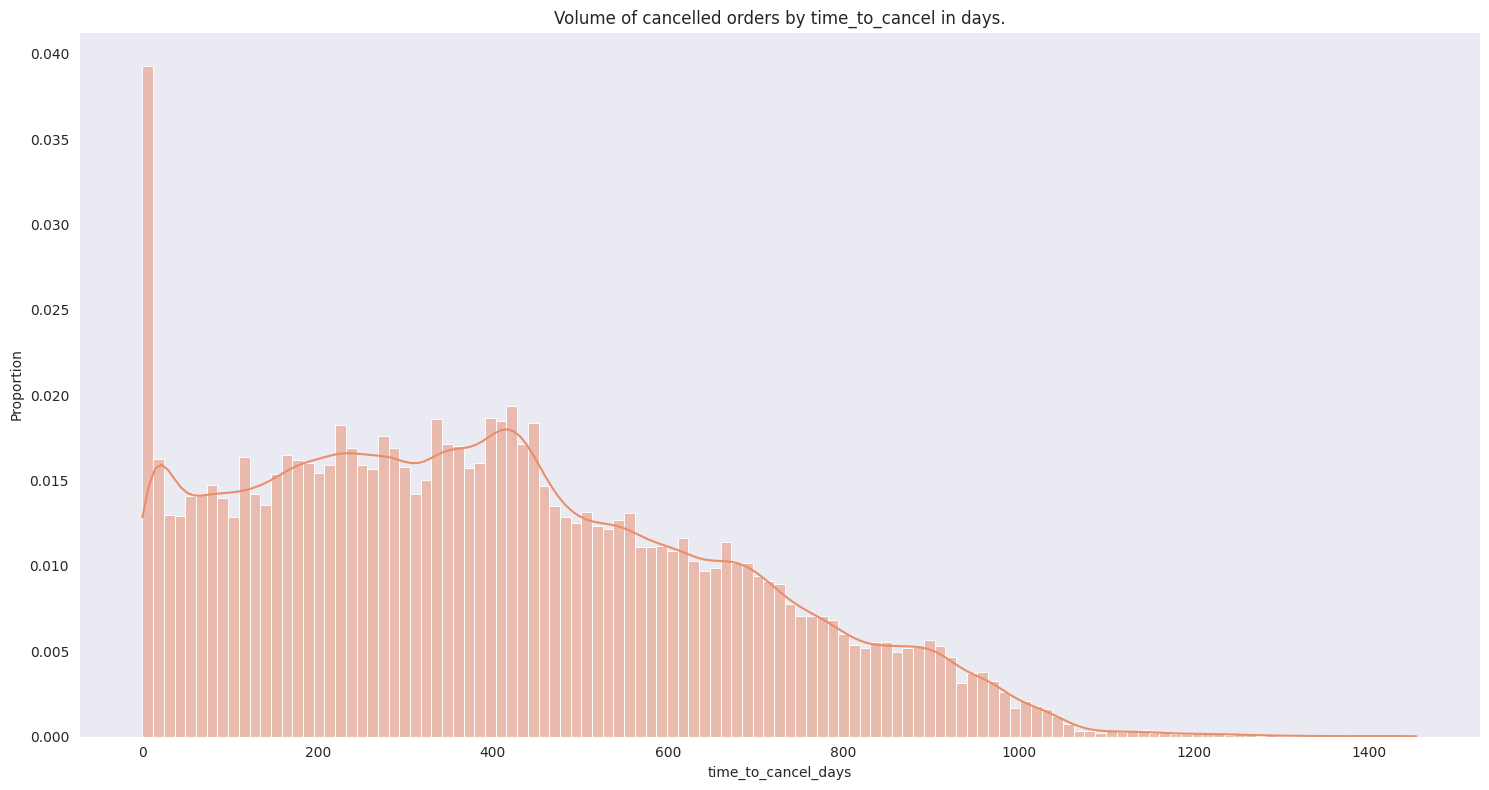

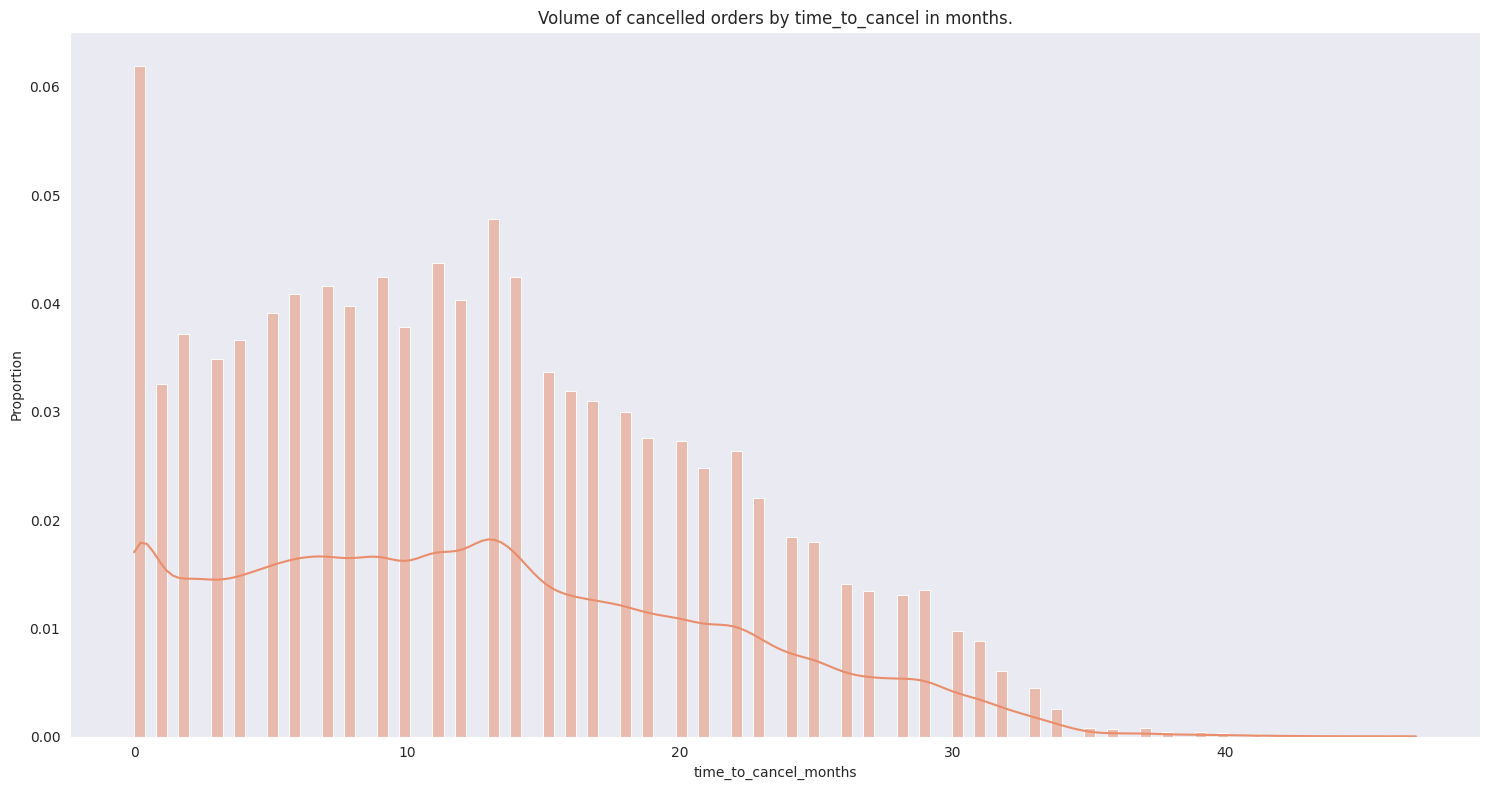

In [44]:
visuals.date_relationship(df.loc[df.order_canceled == True], 'order_date', 'last_update_status_date', 'time_to_cancel')

Now let's verify if the last form fill date is close to the cancellation date (last_update_status_date). 

We'll consider negative time deltas as errors and these cases will be removed. Again we have a feature with high cardinality in the day granularity.

We have a better visualization with a month granularity. Apparently, the cancellation process usually occurs after a few months of the form being completed.

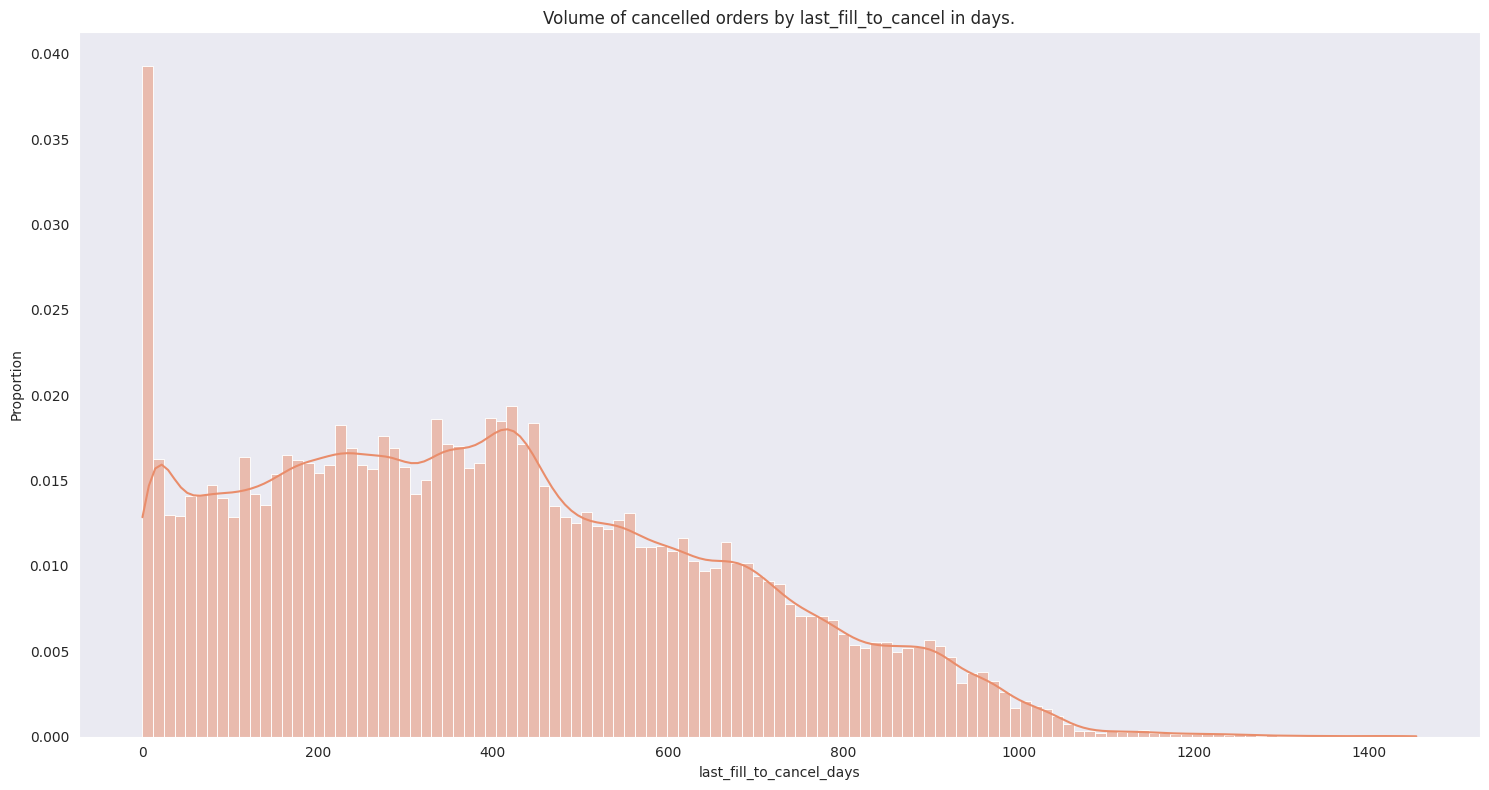

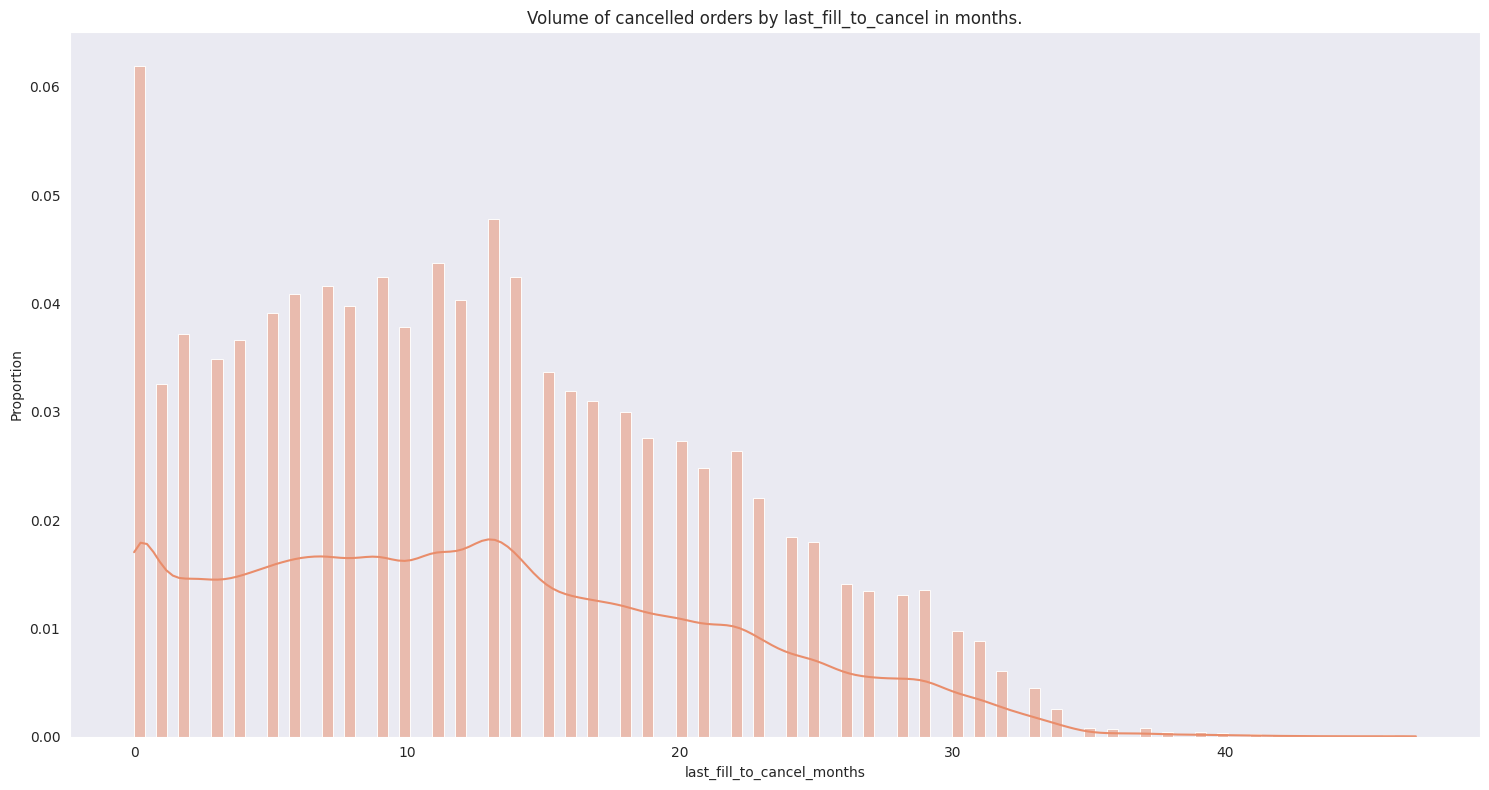

In [45]:
visuals.date_relationship(df.loc[df.order_canceled == True], 'order_date', 'last_update_status_date', 'last_fill_to_cancel')

#### Numerical

In [46]:
numerical_features = df.select_dtypes(include=['int64']).columns
numerical_features

Index(['qty_people', 'qty_dailies', 'qty_status_changes'], dtype='object')

The more people an order has, the less the number of dailies. Probably because it is harder to find a common date to travel. Similarly, the more people, the fewer status changes.

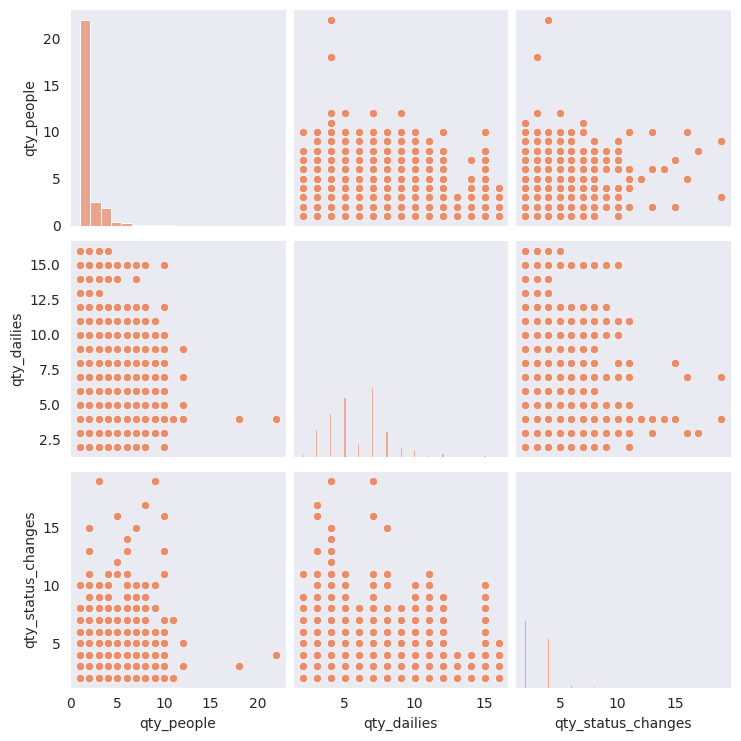

In [47]:
sns.pairplot(df.loc[df.order_canceled == True][numerical_features]);

Most of the cancelled orders had 7 dailies e the majority (around 80%) of cases had 7 or less dailies.

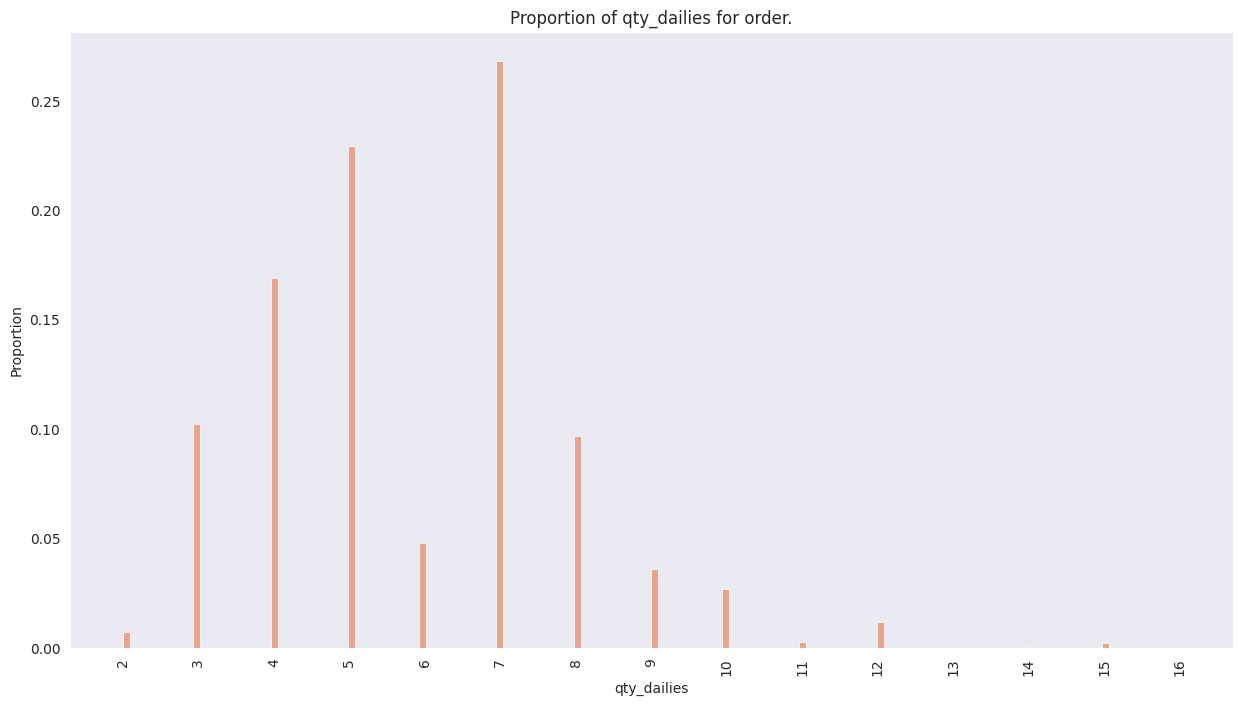

In [48]:
visuals.single_histplot(df.loc[df.order_canceled == True], 'qty_dailies')

In [49]:
(df.loc[df.order_canceled == True].groupby('qty_dailies').count()['order_date'].sort_index()/df.loc[df.order_canceled == True].qty_dailies.count()).cumsum()

qty_dailies
2     0.007290
3     0.109713
4     0.278524
5     0.507754
6     0.555667
7     0.823639
8     0.920432
9     0.956256
10    0.983020
11    0.985546
12    0.997196
13    0.997215
14    0.997482
15    0.999897
16    1.000000
Name: order_date, dtype: float64

Almost 60% of the cases had 2 persons and around 20% had just one traveler.

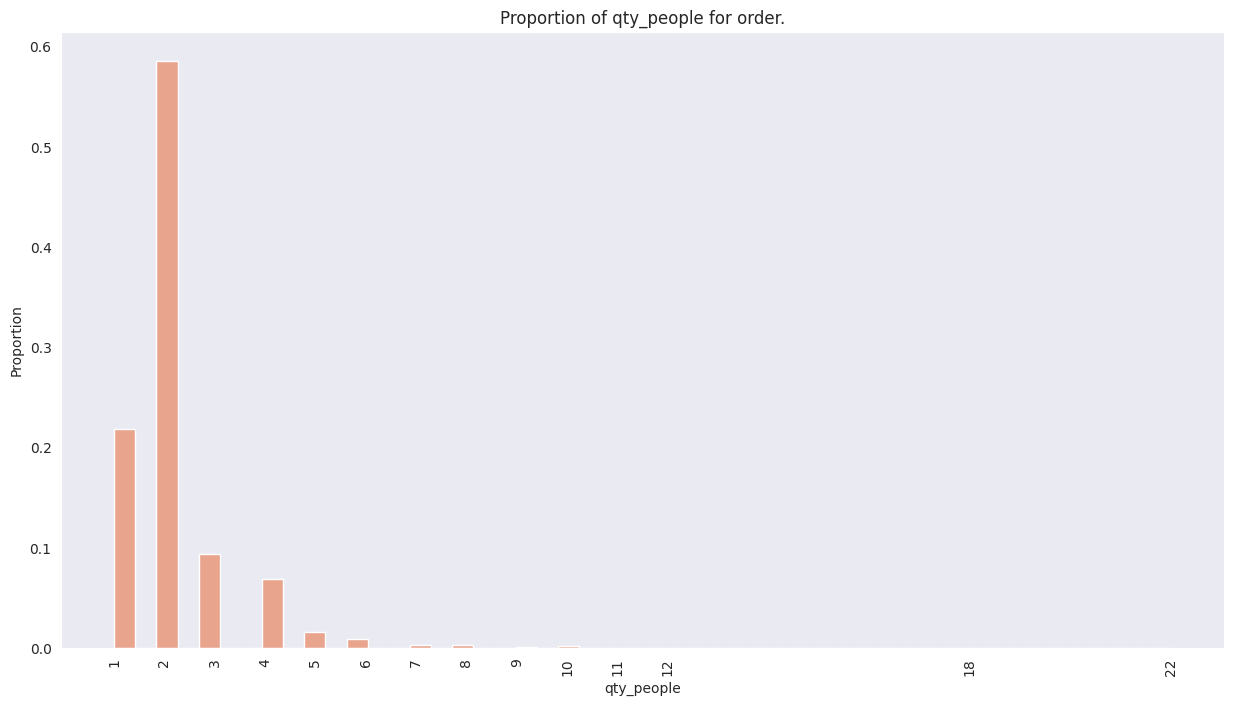

In [50]:
visuals.single_histplot(df.loc[df.order_canceled == True], 'qty_people', bins=50)

Around 25% of the cases had just 2 status changes, in this cases maybe the order was cancelled right away. Less than 25% os the cases had more than 3 status changes.

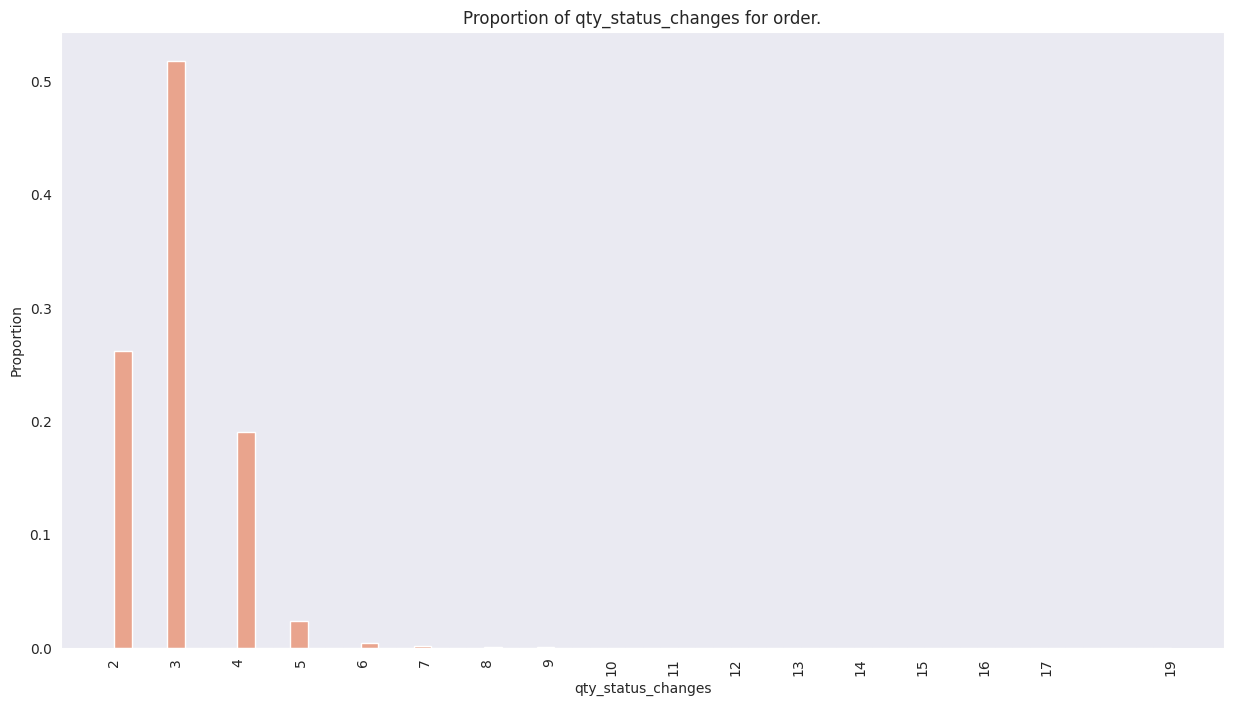

In [51]:
visuals.single_histplot(df.loc[df.order_canceled == True], 'qty_status_changes', bins=60)

Proportionally, most of the orders had their operation started before the cancellation for cases from 3 status changes or more. Being the case of 4 status changes, the one with the biggest difference.

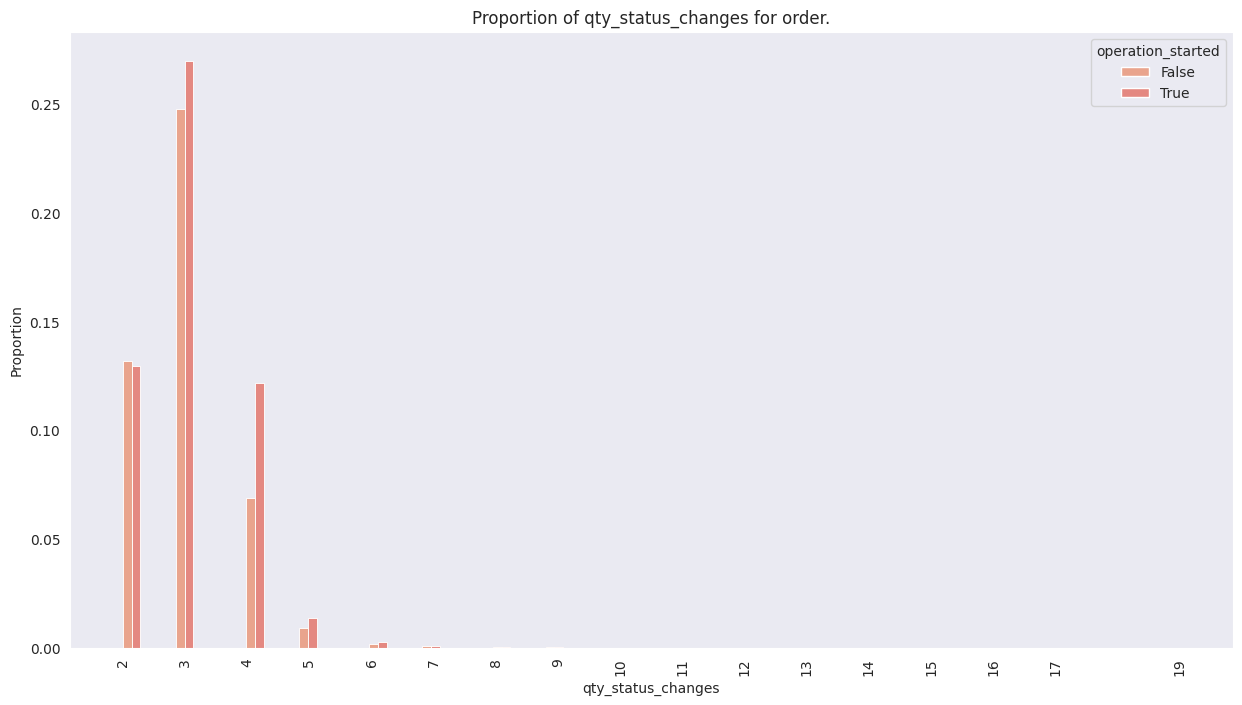

In [52]:
visuals.single_histplot(df.loc[df.order_canceled == True], 'qty_status_changes', bins=60, hue='operation_started', multiple='dodge')

### Modelling - Feature Importance

We'll use a Castboost Classifier to understand which features has more impact on order cancellation. For this, we'll consider categorical and numerical features. We'll disconsider the date features but maintain the numerical ones that refers to it's relationships.

In [53]:
time_to_cancel = utils.build_date_relationship(df,'order_date', 'last_update_status_date', 'time_to_cancel')
last_fill_to_cancel = utils.build_date_relationship(df, 'order_date', 'last_update_status_date', 'last_fill_to_cancel')

In [54]:
df = df.drop(datetime_features, axis=1)

df = df.merge(
    time_to_cancel[['time_to_cancel_days', 'time_to_cancel_months']], left_index=True, right_index=True
    ).merge(
        last_fill_to_cancel[['last_fill_to_cancel_days', 'last_fill_to_cancel_months']], left_index=True, right_index=True
        )

Importing the needed libraries:

In [55]:
import shap
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

shap.initjs()

Transforming the categorical features with LabelEncoder:

In [56]:
categorical_features = df.drop('order_canceled', axis=1).select_dtypes(include=['object_']).columns.to_list()
categorical_features

['origin_city',
 'origin_state',
 'destination_type',
 'destination_city',
 'destination_state',
 'destination_country',
 'accommodation_type',
 'operation_started']

In [58]:
for feature in categorical_features:
    globals()[f'enc_{feature}'] = LabelEncoder()
    df[feature] = globals()[f'enc_{feature}'].fit_transform(df[feature])

The target we'll convert into 0 and 1:

In [59]:
df.loc[df.order_canceled == True, 'order_canceled'] = 1
df.loc[df.order_canceled == False, 'order_canceled'] = 0

In [60]:
df.head()

,origin_city,origin_state,destination_type,destination_city,destination_state,destination_country,qty_people,qty_dailies,accommodation_type,qty_status_changes,operation_started,order_canceled,time_to_cancel_days,time_to_cancel_months,last_fill_to_cancel_days,last_fill_to_cancel_months
0,0,0,1,0,0,0,2,5,0,1,1,0,0,0,0,0
1,11,11,1,111,47,0,2,5,0,1,1,0,0,0,0,0
2,11,11,1,155,58,0,1,6,1,1,1,0,0,0,0,0
3,11,11,1,166,69,0,1,4,0,3,0,1,583,19,583,19
4,11,11,0,177,80,11,4,6,0,1,1,0,0,0,0,0


Split the data into train and test datasets:

In [61]:
X = df.drop('order_canceled', axis=1)
y = df['order_canceled']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Instantiate the Classifier and fit the model:

In [63]:
model = CatBoostClassifier(random_state=42)

In [64]:
fit_model = model.fit(X_train, y_train, eval_set=(X_test, y_test))

Learning rate set to 0.156819
0:	learn: 0.3776847	test: 0.3783307	best: 0.3783307 (0)	total: 100ms	remaining: 1m 40s
1:	learn: 0.2680096	test: 0.2686946	best: 0.2686946 (1)	total: 156ms	remaining: 1m 17s
2:	learn: 0.2247812	test: 0.2255473	best: 0.2255473 (2)	total: 212ms	remaining: 1m 10s
3:	learn: 0.2039292	test: 0.2046888	best: 0.2046888 (3)	total: 288ms	remaining: 1m 11s
4:	learn: 0.1893474	test: 0.1901481	best: 0.1901481 (4)	total: 361ms	remaining: 1m 11s
5:	learn: 0.1793618	test: 0.1802208	best: 0.1802208 (5)	total: 435ms	remaining: 1m 12s
6:	learn: 0.1731679	test: 0.1740520	best: 0.1740520 (6)	total: 504ms	remaining: 1m 11s
7:	learn: 0.1693792	test: 0.1702566	best: 0.1702566 (7)	total: 570ms	remaining: 1m 10s
8:	learn: 0.1663922	test: 0.1673115	best: 0.1673115 (8)	total: 629ms	remaining: 1m 9s
9:	learn: 0.1642083	test: 0.1651542	best: 0.1651542 (9)	total: 703ms	remaining: 1m 9s
10:	learn: 0.1622837	test: 0.1632337	best: 0.1632337 (10)	total: 778ms	remaining: 1m 9s
11:	learn: 0.1

Next, we'll use the shap library to verify which features were more important to the model's performance:

In [65]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)

Below we have an example case where:
- the blue represents the features pushing the result towards zero, i.e. towards a 'no cancellation' label
- on the other hand, the read represents the features pushing the result towards one, i.e. towards a 'cancellation' label

This is a 'not canceled' example:

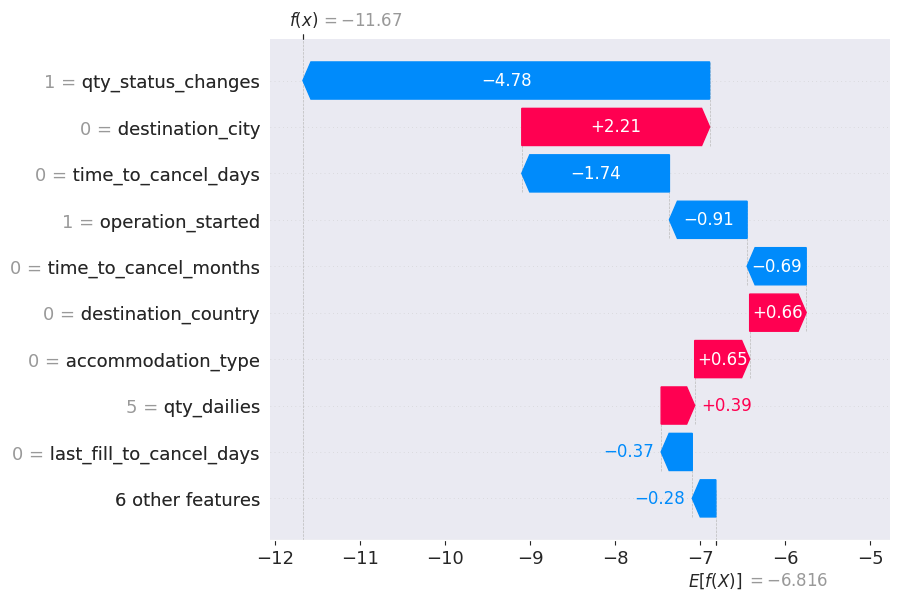

In [ ]:
shap.plots.waterfall(shap_values[0])

As this analysis has some dynamic graphs, you can access [jupyter nbviewer](https://nbviewer.org/github/TamirisCrepalde/survival-analysis/blob/master/notebooks/exploratory_data_analysis/packages_cancellation_analysis.ipynb) to see the complete notebook. 

The force plot below, shows the same case in another perspective:

In [ ]:
shap.plots.force(shap_values[0])

Below there is a 'cancelled' example. One more time we have the feature qty_status_change as the most important. The feature operation_started has also high influence on the output.

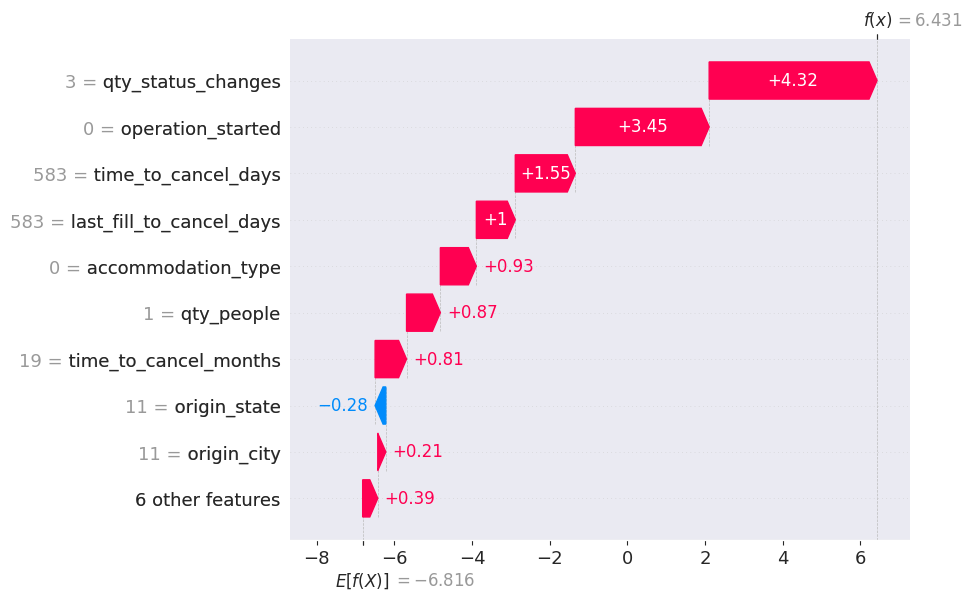

In [72]:
shap.plots.waterfall(shap_values[3])

In [74]:
shap.plots.force(shap_values[3])

We also can plot the explanations for a sample of the dataset, and then explore feature by feature:

* this is a dynamic graph, refers to the link provided below to see it in full

In [75]:
shap_values_sample = explainer.shap_values(shap.sample(X, 1000))
shap.plots.force(explainer.expected_value, shap_values_sample)

As we saw the feature qty_status_changes as the most impactful for the examples above, let's try to understand the effect of this feature in the model output.

The scatter picked time_to_cancel_days to explain the qty_status_changes impact. This is not the best visualization we could have, but it appears that for most of the qty_status_changes values, there's a range of SHAP values that, combined with high time_to_cancel_days, leads to a cancellation. But there is not a well defined threshold at the qty_status_change feature.

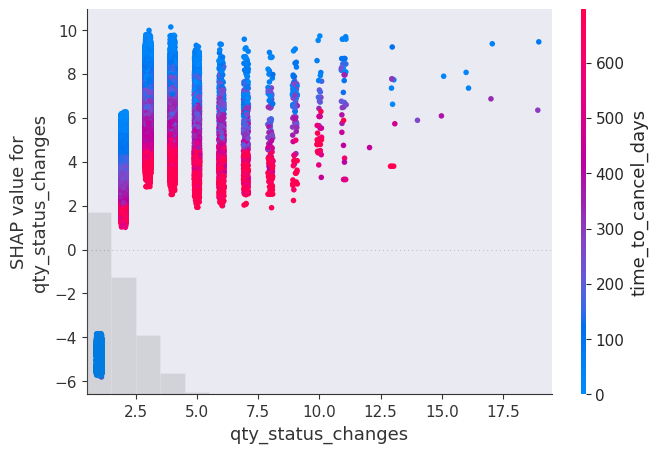

In [77]:
shap.plots.scatter(shap_values[:,"qty_status_changes"], color=shap_values)

Below we have the feature importance for the model, the graph shows the distribution of the each feature's impact on the output. Based on the plot:
- high SHAP values for qty_status_changes, increases the predicted value (towards 'canceled'), and low values reduces the predicted value
- high values of operation_started reduces the predicted value (towards 'not canceled'), and high values increases the predicted value

Other features as time_to_cancel_days, accommodation_type, destination_country and qty_people have also a satisfactory differentiation for high and low SHAP values.

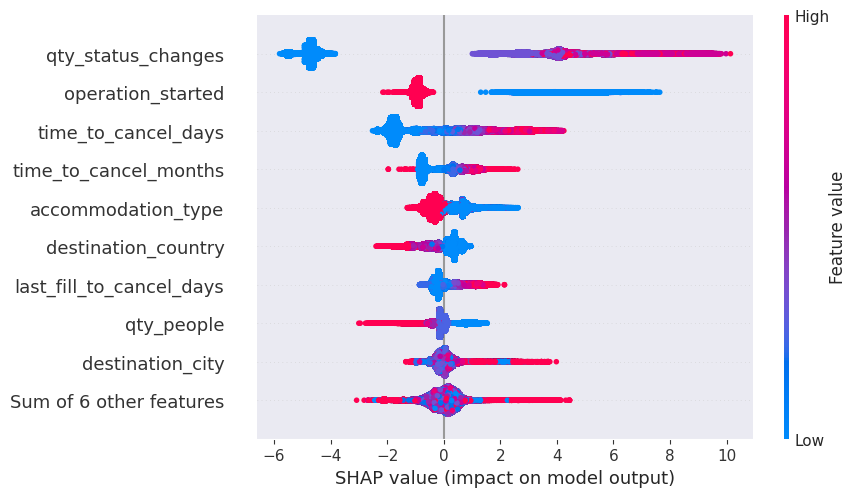

In [ ]:
shap.plots.beeswarm(shap_values)

Finally, below there's the mean absolute value of the SHAP for each feature, validating the qty_status_change as the most impactful feature for cancellation.

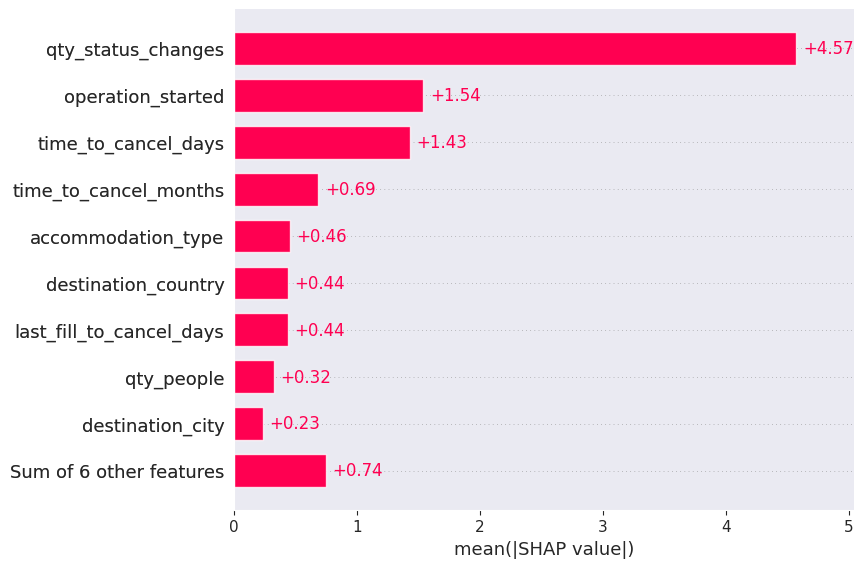

In [ ]:
shap.plots.bar(shap_values)

### Conclusion